In [1]:
import json

def save_jsonl(filename, data):
    with open(filename, "a", encoding="utf-8") as f:
        for entry in data:
            f.write(json.dumps(entry, ensure_ascii=False) + "\n")

In [ ]:
import requests
import time
import random
import re
from urllib.parse import quote
from tqdm import tqdm

# ================= 配置区 =================
# 注意：Cookie 和 X-XSRF-TOKEN 具有时效性，如果报错 432，请去浏览器更新
HEADERS = {
    "User-Agent": "Mozilla/5.0 (iPhone; CPU iPhone OS 14_0 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0 Mobile/15E148 Safari/604.1",
    "Referer": "https://m.weibo.cn/search?containerid=100103type%3D1%26q%3D%E4%BA%BA%E5%B7%A5%E6%99%BA%E8%83%BD",
    "Accept": "application/json, text/plain, */*",
    "X-XSRF-TOKEN": "66b165", 
    "X-Requested-With": "XMLHttpRequest",
    "Cookie": r"WEIBOCN_FROM=1110006030; SCF=AmiWZVLQPNMkQvdooq4ApxGgNrrpZXrPcuw0a7BTKDvTNlSDbLbSF8NTPhzHtSF6KfAPJkwTx-guVDXenouOpoY.; SSOLoginState=1769984898; ALF=1772576898; SUB=_2AkMeI1y0f8NxqwFRmvAdyGrga450yQjEieKof61vJRM3HRl-yT9kqkAStRB6NaNyW4rvhRalIRLW1KUU0hgw5Zuljwmf; SUBP=0033WrSXqPxfM72-Ws9jqgMF55529P9D9WFiKB22RTi3fcM.8QIWI7RG; MLOGIN=0; _T_WM=18452631792; XSRF-TOKEN=66b165; mweibo_short_token=14f9b8e4b4; M_WEIBOCN_PARAMS=lfid%3D102803%26luicode%3D20000174%26uicode%3D20000174"
}

def clean_html(raw_html):
    """清除文本中的 HTML 标签，如 <span class='kt'>..."""
    if not raw_html:
        return ""
    # 去除所有 <> 标签
    clean_re = re.compile('<.*?>')
    return re.sub(clean_re, '', raw_html)

def make_std_json(mblog, keyword):
    """提取单条微博的字段数据"""
    return {
        "source": "weibo",
        "topic": keyword,
        "weibo_id": mblog.get("id"),
        "text": clean_html(mblog.get("text", "")),
        "url": f"https://weibo.com/{mblog.get('user', {}).get('id')}/{mblog.get('id')}",
        "timestamp": mblog.get("created_at"),
        "reposts": mblog.get("reposts_count"),
        "comments": mblog.get("comments_count"),
        "likes": mblog.get("attitudes_count")
    }

def weibo_search_crawler(keyword, max_pages=5):
    results = []
    # 对关键词进行 URL 编码
    encoded_keyword = quote(keyword)
    containerid = f"100103type=1&q={encoded_keyword}"
    
    print(f"--- 正在搜索关键词: {keyword} ---")

    for page in tqdm(range(1, max_pages + 1)):
        url = "https://m.weibo.cn/api/container/getIndex"
        params = {
            "containerid": containerid,
            "page_type": "searchall",
            "page": page
        }

        try:
            resp = requests.get(url, headers=HEADERS, params=params, timeout=10)
            
            if resp.status_code == 432:
                print("\n[ERROR] 触发 432 反爬，请检查 Cookie 或 X-XSRF-TOKEN。")
                break
            if resp.status_code != 200:
                print(f"\n[ERROR] 状态码: {resp.status_code}")
                break

            data = resp.json()
            if data.get("ok") != 1:
                print(f"\n[INFO] 第 {page} 页无数据，抓取结束。")
                break

            cards = data.get("data", {}).get("cards", [])
            page_count = 0

            for card in cards:
                if card.get("mblog"):
                    results.append(make_std_json(card["mblog"], keyword))
                    page_count += 1
                
                elif card.get("card_group"):
                    for item in card.get("card_group"):
                        if item.get("mblog"):
                            results.append(make_std_json(item["mblog"], keyword))
                            page_count += 1
            
            time.sleep(random.uniform(2, 4))    # 随机延时防封

        except Exception as e:
            print(f"\n[异常] {e}")
            break

    return results

if __name__ == "__main__":
    keyword = "人工智能"

    data = search_weibo(keyword, max_pages=100)
    save_jsonl("weibo_data.jsonl", data)
    print("\n" + "="*30)
    print(f"最终抓取总条数: {len(data)}")
    print("="*30)
    
    if data:
        print("前2条预览:")
        for i, item in enumerate(data[:2]):
            print(f"{i+1}. {item['text'][:60]}...")

--- 正在搜索关键词: 人工智能 ---


100%|██████████| 100/100 [06:20<00:00,  3.81s/it]


最终抓取总条数: 969
前2条预览:
1. 人工智能与芯片作为科技前沿领域，难以带来广泛的经济增长，无法以一种经济发展模式的形式，担负起推动社会经济持续发展的历史使...
2. #主播说联播#【#中国专利的含金量满满#】今天，国家知识产权局介绍，我国人工智能专利有效量位居全球前列，并在量子科技、生...


In [79]:
from datetime import datetime
import torch

time_format = '%a %b %d %H:%M:%S %z %Y'

times = [datetime.strptime(item['timestamp'], time_format).timestamp() for item in data]
times = torch.tensor(times, dtype=torch.float64) # 推荐用 float64 保证时间戳精度

target_str = 'Sat Jan 24 00:00:00 +0800 2026'
target_ts = datetime.strptime(target_str, time_format).timestamp()

mask_data = times[times > target_ts]
print(mask_data.shape[0])
print(datetime.fromtimestamp(times.min().item()))
print(datetime.fromtimestamp(times.max().item()))
print(datetime.fromtimestamp(times.mean().item()))

123
2026-01-03 20:07:46
2026-01-24 12:22:08
2026-01-23 06:01:44.835913


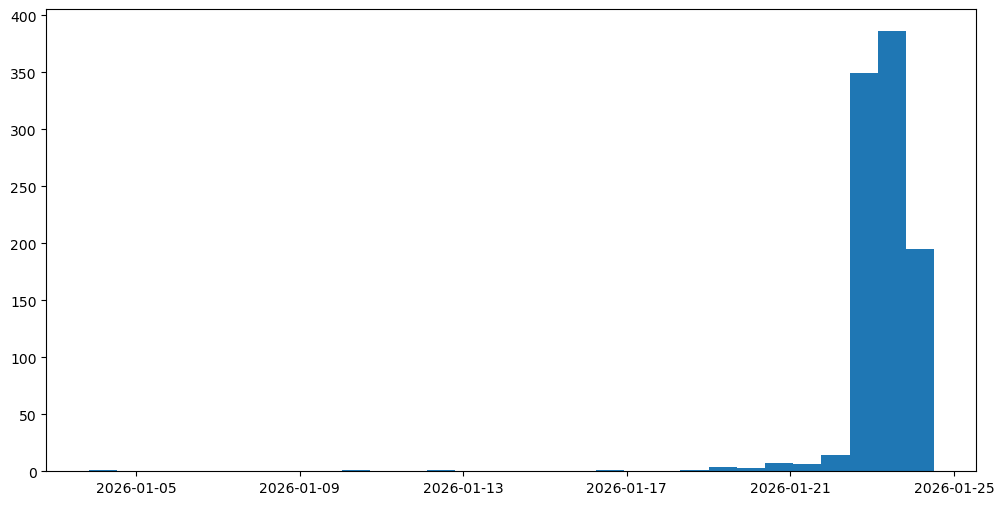

In [80]:
import matplotlib.pyplot as plt

dates = [datetime.fromtimestamp(t.item()) for t in times]

plt.figure(figsize=(12, 6))
plt.hist(dates, bins=30)

plt.show()